# Importação das bibliotecas

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
from scipy.stats import norm


In [6]:
def obter_resumo(tipo_imovel: str, bairro: str = None, banheiro: int = None, quartos: int = None):
    query = f'  tipo_imovel == "{tipo_imovel}"'
    if bairro is not None:
        query += f' and bairro_teste == "{bairro}"  '
    if banheiro is not None:
        query += f' and banheiro == {banheiro} '
    if quartos is not None:
        query += f' and quarto == {quartos} '
    base_original = pd.read_parquet('../data/processed/base_casa_v2.parquet')
    base_original = base_original.query(query)
    return base_original

In [7]:
def obter_estatistica(base_original : pd.DataFrame):
    print('Média preço: ', round(base_original['preco'].mean(), 2))
    print('Mediana Preço:',  base_original['preco'].median())
    print('Moda: ', base_original['preco'].mode()[0])
    print('Desvio Padrão, ', base_original['preco'].std())

# Preço 

- Preço Geral

In [8]:
base_original = obter_resumo(tipo_imovel='Apartamento')
base_original

,tipo_imovel,nome,preco,metragem,quarto,banheiro,garagem,ID_CASA,bairro_teste
0,Apartamento,"Apartamento com 2 Quartos à Venda, 65m²",310000.0,65,2,2,1,2699716579,Jardim Botânico
2,Apartamento,"Apartamento com 2 Quartos à Venda, 71m²",403500.0,71,2,2,2,2690493538,Bonfim Paulista
3,Apartamento,"Apartamento com 2 Quartos à Venda, 54m²",290000.0,54,2,2,1,2667652105,Nova Aliança
4,Apartamento,"Apartamento com 2 Quartos à Venda, 45m²",166420.0,45,2,1,1,2682840782,Conjunto Habitacional Jardim Das Palmeiras
5,Apartamento,"Apartamento com 2 Quartos à Venda, 64m²",370000.0,64,2,2,2,2688027260,Vila Ana Maria
...,...,...,...,...,...,...,...,...,...
9967,Apartamento,"Apartamento com 3 Quartos à Venda, 81m²",540000.0,81,3,2,2,2696267182,Vila Do Golf
9968,Apartamento,"Apartamento com Quarto à Venda, 61m²",280000.0,61,1,1,1,2476716299,Centro
9969,Apartamento,"Apartamento com 3 Quartos à Venda, 83m²",375000.0,83,3,3,2,2693112449,Jardim São Luiz
9970,Apartamento,"Apartamento com 2 Quartos à Venda, 48m²",175000.0,48,2,1,1,2572455642,Lagoinha


In [9]:
base_original['bairro_teste'].value_counts().reset_index()

,bairro_teste,count
0,Jardim Botânico,739
1,Centro,736
2,Nova Aliança,661
3,Jardim Irajá,353
4,Jardim Paulista,315
...,...,...
154,Jardim Do Trevo,1
155,Jardim Juliana,1
156,Jardim Valentina Figueiredo,1
157,Zona Sul,1


In [10]:
base_original['bairro_teste'].unique()

<StringArray>
[                           'Jardim Botânico',
                            'Bonfim Paulista',
                               'Nova Aliança',
 'Conjunto Habitacional Jardim Das Palmeiras',
                             'Vila Ana Maria',
                           'Jardim Republica',
                                   'Lagoinha',
                              'Jardim Sumare',
                    'Parque Dos Bandeirantes',
                                   'Ipiranga',
 ...
                                 'Royal Park',
                        'Reserva San Gabriel',
                   'Jardim Roberto Benedetti',
                            'Jardim Mosteiro',
                             'Jardim Juliana',
                            'Reserva Do Golf',
                'Jardim Valentina Figueiredo',
                          'Planalto Verde Vi',
                                   'Zona Sul',
                    'Condominio Garden Ville']
Length: 159, dtype: string

In [11]:
n = base_original.shape[0]
k = 1 + (10 / 3) * np.log10(n)
k = int(k.round(0))

k

14

In [12]:
base_original.describe()

,preco,metragem,quarto,banheiro,garagem,ID_CASA
count,8.395000e+03,8395.000000,8395.000000,8395.000000,8395.000000,8.395000e+03
mean,4.506409e+05,87.229780,2.315307,2.095771,1.463133,2.635153e+09
std,4.534368e+05,87.683108,0.766401,1.319427,2.232691,9.835162e+07
min,6.104500e+04,10.000000,1.000000,1.000000,0.000000,5.447240e+07
25%,2.150000e+05,49.000000,2.000000,1.000000,1.000000,2.603213e+09
50%,3.200000e+05,70.000000,2.000000,2.000000,1.000000,2.658819e+09
75%,5.200000e+05,103.000000,3.000000,3.000000,2.000000,2.678281e+09
max,8.000000e+06,4687.000000,20.000000,20.000000,192.000000,2.700625e+09


In [13]:
base_original['metragem_bins'] = pd.qcut(
    base_original['metragem'], q=k).astype('str')

In [14]:
base_original['metragem_bins'].value_counts()

metragem_bins
(45.0, 48.0]       751
(9.999, 42.0]      683
(58.0, 65.0]       639
(77.0, 86.0]       614
(110.0, 128.0]     604
(96.0, 110.0]      597
(167.0, 4687.0]    595
(128.0, 167.0]     594
(65.0, 70.0]       592
(86.0, 96.0]       590
(52.0, 58.0]       584
(42.0, 45.0]       580
(70.0, 77.0]       530
(48.0, 52.0]       442
Name: count, dtype: int64

In [15]:
fig = px.box(base_original, x='metragem_bins', y='preco', category_orders={})
fig.update_layout( xaxis={
                  'categoryorder': 'category ascending'})

fig.show()

In [16]:
obter_estatistica(base_original=base_original)

Média preço:  450640.89
Mediana Preço: 320000.0
Moda:  250000.0
Desvio Padrão,  453436.77386399714


In [17]:
fig = px.box(base_original, y='preco')
fig.show()

In [18]:
fig = px.histogram(base_original, x='preco', nbins=k)
fig.update_layout(bargap=0.2)
fig.show()

# Total Quartos

In [19]:
base_original['quarto'].value_counts()

quarto
2     4028
3     3000
1     1040
4      312
5       13
20       1
8        1
Name: count, dtype: int64

# Total Garagem

In [20]:
base_original['garagem'].value_counts()

garagem
1      5080
2      2455
3       386
0       260
4       172
5        22
6        10
8         4
10        2
7         2
192       1
19        1
Name: count, dtype: int64

# Teste da normalidade de uma amostra

In [21]:
from scipy.stats import normaltest

In [22]:
base_original_completa = obter_resumo(tipo_imovel='Apartamento')
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"')
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"')

In [59]:
significancia = 0.05

In [60]:
stat_test, p_valor = normaltest(dados_sumarezinho.preco)

In [61]:
p_valor <= significancia

True

In [62]:
stat_test, p_valor = normaltest(dados_centro.preco)
p_valor <= significancia

True

In [63]:

import warnings
warnings.filterwarnings("ignore")
for bairro in base_original['bairro_teste'].unique():
    try:
        dados_sumarezinho = base_original_completa.query(
            f'bairro_teste == "{bairro}"')
        
        stat_test, p_valor = normaltest(dados_sumarezinho.preco)
        print(
            f'Teste de Normalidade para o bairro {bairro} => {p_valor <= significancia} ')
    except:
        pass

Teste de Normalidade para o bairro Jardim Botânico => True 
Teste de Normalidade para o bairro Bonfim Paulista => True 
Teste de Normalidade para o bairro Nova Aliança => True 
Teste de Normalidade para o bairro Conjunto Habitacional Jardim Das Palmeiras => True 
Teste de Normalidade para o bairro Vila Ana Maria => True 
Teste de Normalidade para o bairro Jardim Republica => False 
Teste de Normalidade para o bairro Lagoinha => True 
Teste de Normalidade para o bairro Jardim Sumare => True 
Teste de Normalidade para o bairro Parque Dos Bandeirantes => True 
Teste de Normalidade para o bairro Ipiranga => True 
Teste de Normalidade para o bairro Vila Monte Alegre => True 
Teste de Normalidade para o bairro Parque Dos Lagos => True 
Teste de Normalidade para o bairro Alto Da Boa Vista => True 
Teste de Normalidade para o bairro Jardim Presidente Medici => True 
Teste de Normalidade para o bairro Vila Virginia => True 
Teste de Normalidade para o bairro Jardim Itaú => False 
Teste de Norma

Teste de Normalidade para o bairro Jardim Irajá => True 
Teste de Normalidade para o bairro Reserva Sul Condomínio Resort => True 
Teste de Normalidade para o bairro Jardim Independencia => False 
Teste de Normalidade para o bairro Iguatemi => True 
Teste de Normalidade para o bairro Recanto Das Palmeiras => False 
Teste de Normalidade para o bairro Vila Amélia => True 
Teste de Normalidade para o bairro Ribeirânia => True 
Teste de Normalidade para o bairro Residencial Flórida => False 
Teste de Normalidade para o bairro Quintino Facci Ii => False 
Teste de Normalidade para o bairro Jardim Paulistano => True 
Teste de Normalidade para o bairro Jardim Florestan Fernandes => True 
Teste de Normalidade para o bairro Jardim Paulista => True 
Teste de Normalidade para o bairro Jardim Interlagos => False 
Teste de Normalidade para o bairro Centro => True 
Teste de Normalidade para o bairro Planalto Verde I => False 
Teste de Normalidade para o bairro Quinta Da Primavera => False 
Teste de N

# Teste de hipótese

<ul>
    <li>u1: Média dos imóveis do bairro sumarezinho </li>
    <li>u2: Média dos imóveis do bairro Centro </li>
    <li>H0: u1 <= u2</li>
    <li>H1: u1 > u2 XXX</li>
<ul>

In [64]:
significancia = 0.01
confianca = 1 - significancia

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit

In [66]:
base_original_completa = obter_resumo(tipo_imovel='Apartamento')

In [89]:
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"')
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"')
dados_jardim_macedo = base_original_completa.query(
    'bairro_teste == "Jardim Itaú"')
dados_sao_jose = base_original_completa.query(
    'bairro_teste == "Jardim Sao Jose"'
)

In [68]:
def obter_numero_classe(dataframe: pd.DataFrame):
    n = dataframe.shape[0]


    k = 1 + (10 / 3) * np.log10(n)
    k = int(k.round(0))

    return k

<Axes: xlabel='preco', ylabel='Count'>

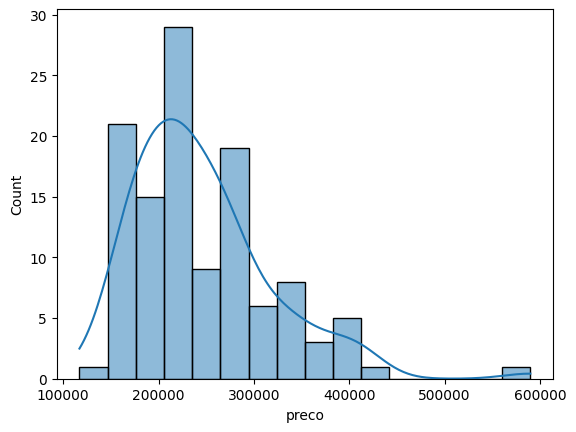

In [81]:

k = obter_numero_classe(dados_sumarezinho)
sns.histplot(data=dados_sumarezinho, x='preco', kde=True)

<Axes: xlabel='preco', ylabel='Count'>

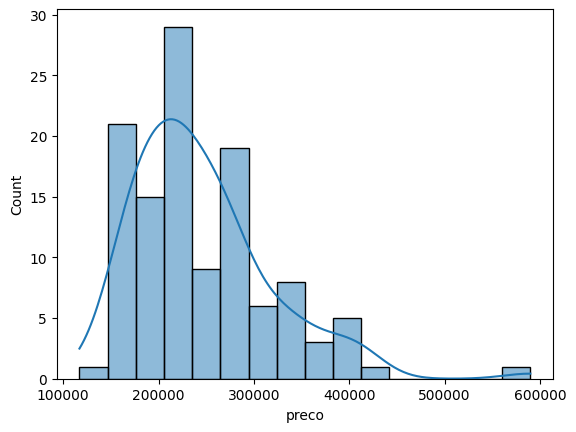

In [78]:
sns.histplot(data=dados_sumarezinho, x='preco', kde=True)

<Axes: xlabel='preco', ylabel='Count'>

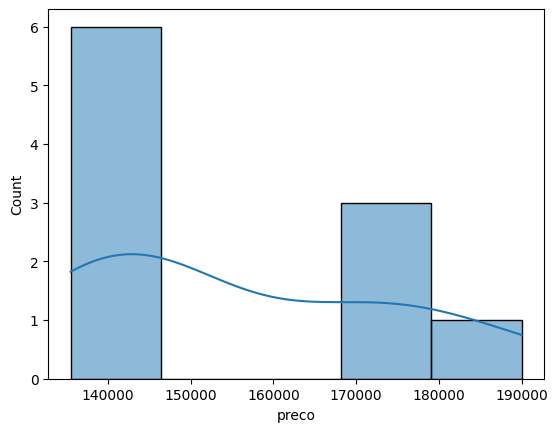

In [77]:
k = obter_numero_classe(dados_jardim_macedo)
sns.histplot(data=dados_jardim_macedo, x='preco', kde=True)

In [72]:
obter_estatistica(dados_jardim_macedo)

Média preço:  155900.0
Mediana Preço: 145500.0
Moda:  140000.0
Desvio Padrão,  19039.14097035076


<Axes: xlabel='preco', ylabel='Count'>

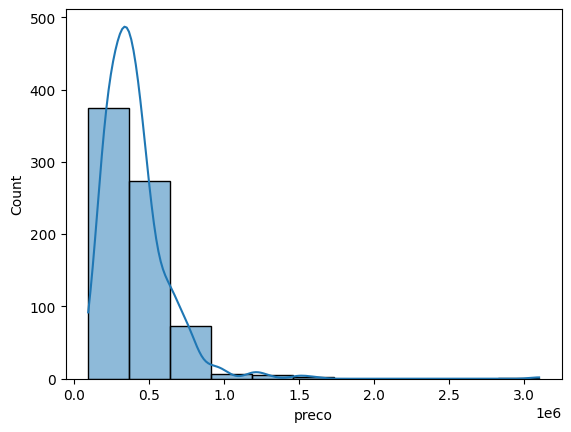

In [84]:

k = obter_numero_classe(dados_centro)
sns.histplot(data=dados_centro, x='preco', bins=k, kde=True)

In [82]:
obter_estatistica(dados_centro)

Média preço:  402076.73
Mediana Preço: 360000.0
Moda:  450000.0
Desvio Padrão,  223344.45525125158


In [90]:
dados_sao_jose

,tipo_imovel,nome,preco,metragem,quarto,banheiro,garagem,ID_CASA,bairro_teste
674,Apartamento,"Apartamento com 2 Quartos à Venda, 65m²",308000.0,65,2,1,2,2575583579,Jardim Sao Jose
1305,Apartamento,"Apartamento com 2 Quartos à Venda, 65m²",278000.0,65,2,1,2,2678280326,Jardim Sao Jose
2053,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",313000.0,63,2,1,2,2662549930,Jardim Sao Jose
2221,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",300000.0,63,2,1,2,2666104406,Jardim Sao Jose
3147,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",310000.0,63,2,1,2,2662551418,Jardim Sao Jose
4380,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",290000.0,63,2,2,2,2662551039,Jardim Sao Jose
4779,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",310000.0,63,2,1,1,2673856605,Jardim Sao Jose
5155,Apartamento,"Apartamento com 3 Quartos à Venda, 75m²",400000.0,75,3,2,2,2610140073,Jardim Sao Jose
5442,Apartamento,"Apartamento com 3 Quartos à Venda, 75m²",450000.0,75,3,2,2,2670049396,Jardim Sao Jose
5681,Apartamento,"Apartamento com 2 Quartos à Venda, 63m²",320000.0,63,2,1,0,2694821076,Jardim Sao Jose


<Axes: xlabel='preco', ylabel='Count'>

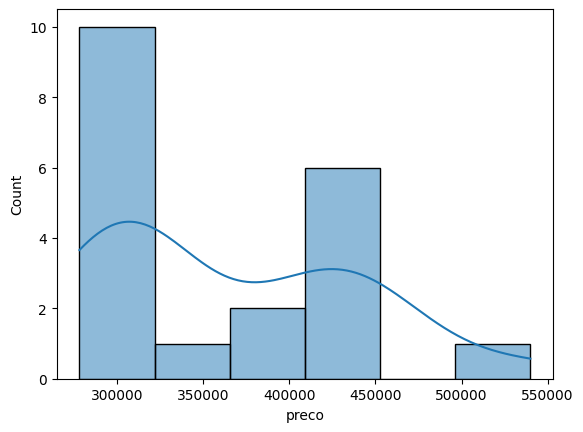

In [92]:
sns.histplot(data=dados_sao_jose, x='preco', kde=True)

In [93]:
obter_estatistica(dados_sao_jose)

Média preço:  365700.0
Mediana Preço: 325000.0
Moda:  450000.0
Desvio Padrão,  75432.8561667506


In [97]:
dados_sumarezinho = base_original_completa.query(
    'bairro_teste == "Sumarezinho"').preco
dados_centro = base_original_completa.query(
    'bairro_teste == "Centro"').preco

In [98]:
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

In [99]:
test_sumarezinho = DescrStatsW(dados_sumarezinho)
test_centro = DescrStatsW(dados_centro)

In [100]:
test_a = test_sumarezinho.get_compare(test_centro)

In [101]:
test_a.ztest_ind(alternative='larger', value=0)

(-7.546571978952292, 0.9999999999999777)

In [102]:
z, p_valor = test_a.ztest_ind(alternative='larger', value=0)

In [103]:
p_valor <= significancia

False

In [104]:
test_a = CompareMeans(test_centro, test_sumarezinho)

In [105]:
teste_b = CompareMeans(test_centro, test_sumarezinho)

# Teste de shapiro-wilk

In [106]:
from scipy import stats

In [107]:
resultado = stats.shapiro(dados_sumarezinho)
resultado.pvalue

2.5383620915016895e-07

# Intervalo de confiança

In [24]:
import numpy as np
from scipy.stats import t

conf_level = 0.95
media = dados_centro['preco'].mean()
std = dados_centro['preco'].std()
n = dados_centro.shape[0]
grausLiberdade = n - 1
t_value = t.ppf((1 + conf_level) / 2, grausLiberdade)
inf = media - t_value * std / np.sqrt(n)
sup = media + t_value * std / np.sqrt(n)
print('Média:', round(media), ' Desvio padrão:', round(std))
# Imprime o intervalo de confiança para a média
print('Intervalo de confiança:', round(inf), '-', round(sup))

Média: 402077  Desvio padrão: 223344
Intervalo de confiança: 385915 - 418239
